# Généralisation aux régressions multi-linéaires

Dans le [cahier précédant](./01_regression_lineaire.ipynb) nous avons vu les régression linéaire en dimension 1, qui correspondent aux droites cherchant à approximer un nuage de points.
Rien ne nous empêche de généraliser cette méthode à des espaces de dimensions supérieures. Les formules et les méthodes seront toujours valables.

Or le [premier cahier](./00_concepts.ipynb) de ce répertoire a montré qu'on pouvait ainsi aussi faire des régression polynomiale, ce que nous allons expérimenter maintenant.

## Régression polynomiale

Pour nous entraîner, nous générons une courbe polynomiale autour de laquelle nous introduisons un bruit stochastique. L'objectif sera ensuite de retrouver le polynôme d'origine.

Pour des raisons d'efficacité, nous utilisons les [polynomes de NumPy](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.Polynomial.html#numpy.polynomial.polynomial.Polynomial).


In [145]:
import numpy as np
import matplotlib.pyplot as plt

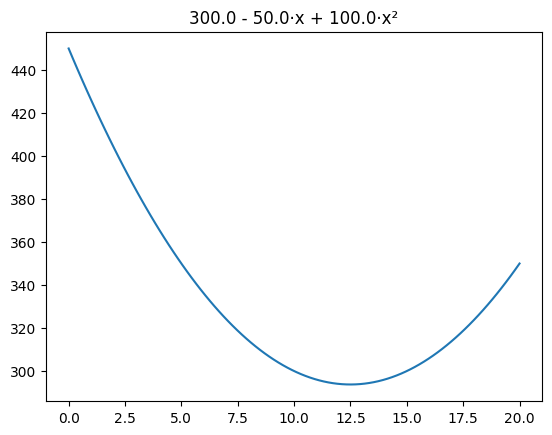

In [171]:
from numpy.polynomial import Polynomial

# construit un polynôme à partir de ses racines pour mieux contrôler son apparence
# roots = [1, 4, 15]
roots = [10, 15]
P = Polynomial.fromroots(roots, domain=[0,20])
P = P + 300

# affichage
nb_pts = 100
x0,y0 = P.linspace(nb_pts)      # génère les points à afficher (par défaut 100)
plt.plot(x0,y0)
plt.title(f'{P:unicode}')
plt.show()

## Floutage de la courbe

Je rajoute maintenant du bruit pour flouter cette courbe avec une distribution [normale](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal).

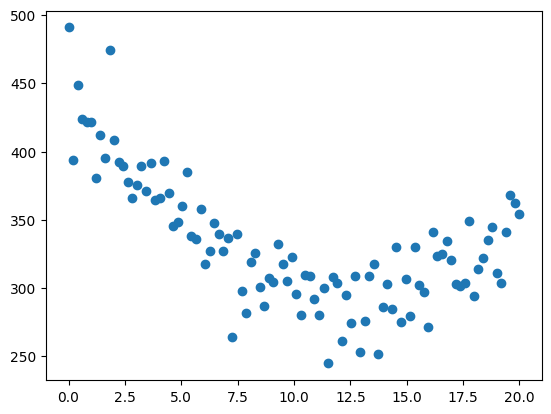

In [172]:
rng = np.random.default_rng(3)

x = x0
coef = 20   # ajuste le désordre autour de la référence
y = y0 + rng.normal(scale = coef, size = nb_pts)

plt.scatter(x,y)
plt.show()

## Prémière régression avec la méthode '`fit`' de l'objet '`Polynomial`'

Nous recherchons maintenant le polynôme de degré 3 s'adaptant au mieux à ces points. 

Tout d'abord, nous commençons par utiliser la méthode [fit](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.Polynomial.fit.html) prévue par Numpy.

In [175]:
# P1 = P.fit(x,y, deg=3)       # trouve le polynôme adapté au nuage de points
P1 = P.fit(x,y, deg=2)

x1,y1 = P1.linspace(nb_pts)

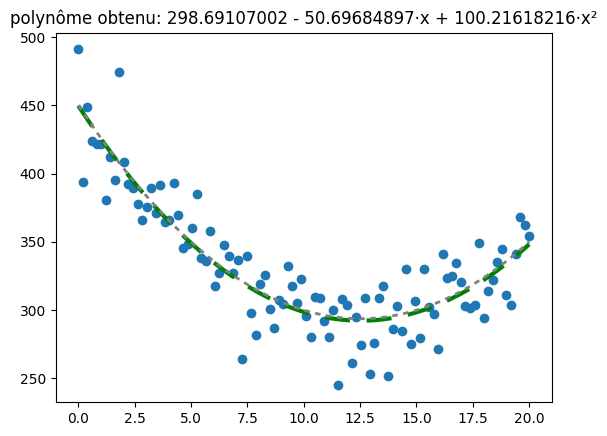

In [176]:
plt.plot(x1,y1, linewidth=3, color='green', dashes=[6,4])

plt.plot(x0,y0, linewidth=2, color='gray', dashes=[2,2])   # le polynôme d'origine
plt.scatter(x,y)                                               # le nuage de points


plt.title(f'polynôme obtenu: {P1:unicode}')
plt.show()

## Reconstruction de la méthode des moindres carrés

Nous ré-écrivons ici la méthode de moindres carrés, qui est en fait déjà utilisée par Numpy dans la méthode `fit`.

Il faut trouver le paramètre $\theta$ qui annule le gradient de la fonction coût. Nous avions vu l'expression de ce gradient dans le [cahier d'introduction](./00_concepts.ipynb).

$$ \frac{\partial{J}(\theta)}{\partial{\theta}} = \frac{1}{m} X^T \times (X\times\theta -  Y)$$

Il faut donc résoudre.

$$\begin{align*}
&X^T (X \theta -  Y) = 0\\
&X^T X \,\theta =  X^T Y \\
\end{align*}$$

C'est-à dire

$$ \theta = (X^T\times X)^{-1}\times X^T \times Y$$

In [177]:
L  = len(x)
x = x.reshape(L, 1)
y = y.reshape(L, 1)

# X = np.hstack((np.ones(L).reshape(L,1), x, x**2, x**3))
X = np.hstack((np.ones(L).reshape(L,1), x, x**2))

print(x.shape, y.shape, X.shape, X[2,:])

(100, 1) (100, 1) (100, 3) [1.         0.4040404  0.16324865]


On applique la formule

$$ \theta = (X^T\times X)^{-1}\times X^T \times Y$$

In [178]:
from numpy.linalg import inv

XT = X.T
XTY = XT @ y

XTX = XT @ X
XTX_1= inv(XTX)

theta = XTX_1 @ XTY
# M = XTX_1.dot(XT)
# theta = M.dot(y)
theta = theta.ravel() # revenir à 1d
theta = list(theta)   # reconvertir en liste simple
theta

[449.6041011579083, -25.112921329420278, 1.0021618216041983]

In [179]:
theta.reverse()
theta

[1.0021618216041983, -25.112921329420278, 449.6041011579083]

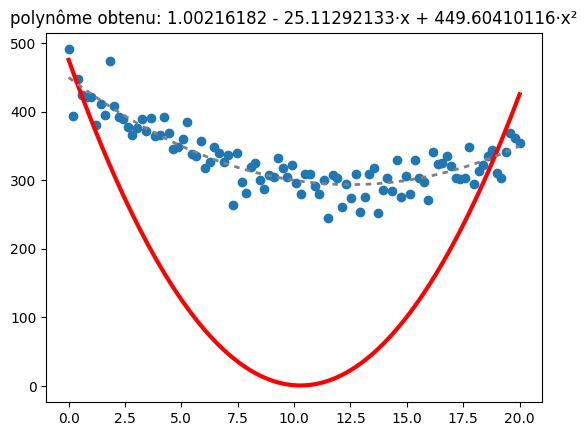

In [180]:

P2 = Polynomial(theta, domain=[0,20])

x2,y2 = P2.linspace(nb_pts)
plt.plot(x2,y2, linewidth=3, color='red')

plt.plot(x0,y0, linewidth=2, color='gray', dashes=[2,2])   # le polynôme d'origine
plt.scatter(x,y)                                               # le nuage de points

plt.title(f'polynôme obtenu: {P2:unicode}')
plt.show()

## Résolution pour la méthode du gradient

Nous reprenons maintenant avec la méthode montré dans le [cahier d'introduction](./00_concepts.ipynb).

In [181]:
L  = len(x)
x = x.reshape(L, 1)
y = y.reshape(L, 1)

# X = np.hstack((np.ones(L).reshape(L,1), x, x**2, x**3))
X = np.hstack((np.ones(L).reshape(L,1), x, x**2))

print(x.shape, y.shape, X.shape, X[2,:])

(100, 1) (100, 1) (100, 3) [1.         0.4040404  0.16324865]


In [182]:
preprocessing = True     # indiquer ici si on veut normaliser les données
if preprocessing:
    x_min = x.min()
    x_range = x.max() - x_min
    y_min = y.min()
    y_range = y.max() - y_min

    def transf(x, y):         
        return (x - x_min) / x_range , (y - y_min) / y_range

    def inv_transf(x,y):        
        return x * x_range + x_min, y * y_range + y_min
    
    def inv_transf_y(y):        
        return y * y_range + y_min

    # ces fonctions sont définies à la va-vite, on trouvera mieux ici:
    # voir https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler.inverse_transform
    x,y = transf(x, y)


In [183]:
if preprocessing:
    # theta = rng.random(4).reshape(4,1)
    theta = rng.random(3).reshape(3,1)
    # print(theta)
else:
    theta = np.array([10,-200,1000,1000]).reshape(4,1)

inverted = False

def model(X, theta):
    return X.dot(theta)

def cost_function(X, y, theta):
    m = y.shape[0]
    return 1 / (2*m) * np.sum(np.square(model(X,theta) -y))

def grad(X,y,theta):
    m = y.shape[0]
    return 1/m * X.T.dot(model(X, theta) -y)

def gradient_descent(X,y,theta, learning_rate, n_iterations):
    cost_history = np.zeros(n_iterations)
    for i in range(0, n_iterations):
        theta = theta - learning_rate * grad(X,y,theta)
        cost_history[i] = cost_function(X,y,theta)
    return theta, cost_history

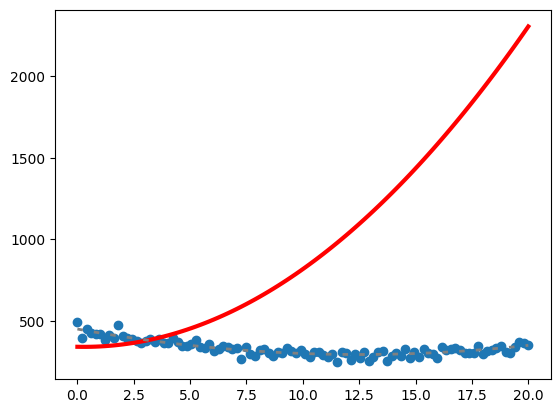

In [186]:
# paramètres fonctionnant pour les deux situations
if preprocessing:
    rate = 0.00000001
    nb_iterations = 10000
    # si nous relançons cette cellule, il faut re-transformer les x,y
    if inverted:
        x,y = transf(x,y)        
else:
    rate = 0.000000000001
    nb_iterations = 500000

theta_final, cost_history = gradient_descent(X,y,theta, learning_rate=rate, n_iterations=nb_iterations)
prediction = model(X, theta_final)

if preprocessing:    
    # on remet les valeurs dans leur domaine d'origine
    x, y = inv_transf(x, y)
    prediction = inv_transf_y(prediction)
    # mémoriser l'action
    inverted = True
    

plt.scatter(x,y)  # le nuage de points

plt.plot(x, prediction, c='r', lw=3)           # les prédictions qui viennent d'être faites
plt.plot(x0, y0, c='gray', lw=2, dashes=[2,4]) # le polynôme d'origine

plt.show()

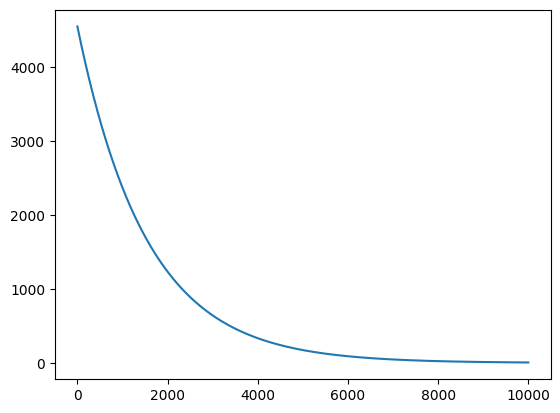

In [187]:
plt.plot(range(0,len(cost_history)), cost_history)